<a href="https://colab.research.google.com/github/brian386/ScanChessOnline/blob/master/chessboard_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(1517, 2653, 3)


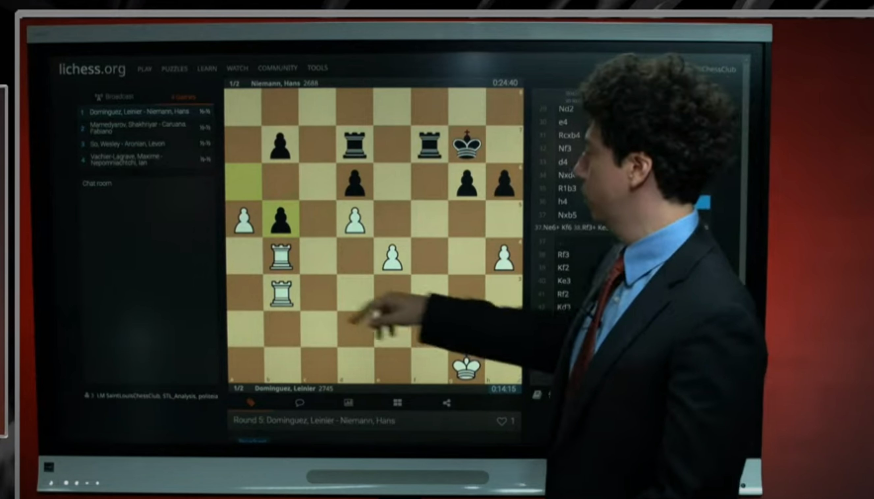

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math
img = cv2.imread('./test3.jpg')
print(img.shape)
# img = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)
scale_percent = 500/img.shape[0]
img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))
cv2_imshow(img)

scale_percent = 500/img.shape[0]
img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))

In [2]:
def edge_detect(img, low_threshold=70, high_threshold=200):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(img_gray, low_threshold, high_threshold)
  return edges

def get_lines(img):
  rho = 1  # distance resolution in pixels of the Hough grid
  theta = np.pi / 180  # angular resolution in radians of the Hough grid
  threshold = 50  # minimum number of votes (intersections in Hough grid cell)
  min_line_length = 50  # minimum number of pixels making up a line
  max_line_gap = 25  # maximum gap in pixels between connectable line segments

  # Run Hough on edge detected image
  # Output "lines" is an array containing endpoints of detected line segments
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                      min_line_length, max_line_gap)
  return lines
def show_lines(img, lines):
  line_image = np.copy(img) * 0  # creating a blank to draw lines on
  line_id = []
  for i,line in enumerate(lines):
    # print(line)
    if len(line) > 0:
      x1, y1, x2, y2 = line[0]
      x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)

      length = math.sqrt((y2-y1)**2 + (x2-x1)**2)
      if(length > 30):
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)
        line_id.append(line[0])
  cv2_imshow(line_image)
  return line_id
  


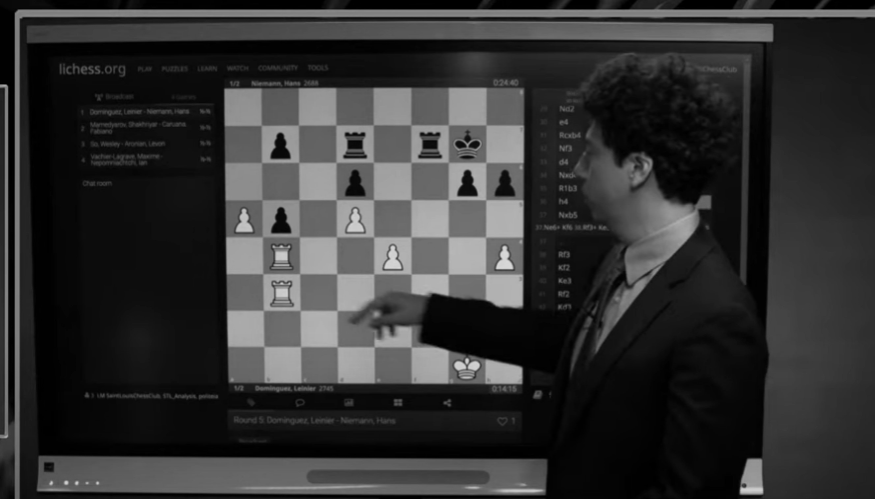

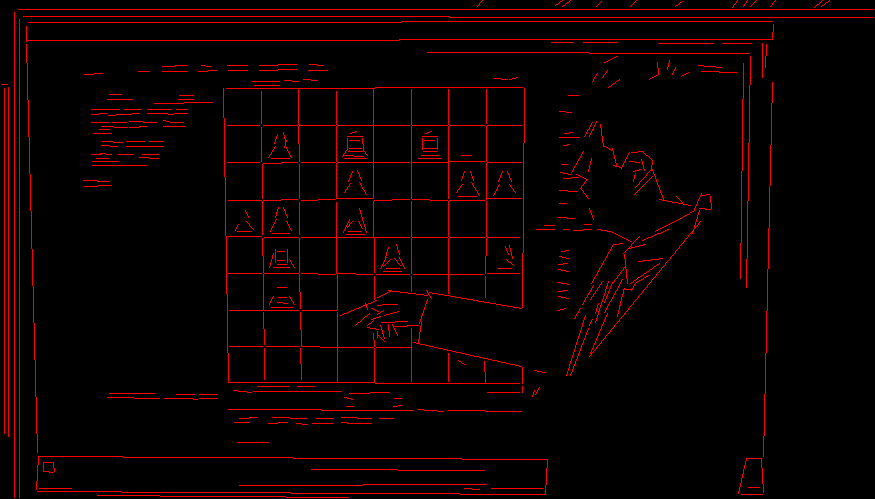

In [3]:
ed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
drawn_img = np.copy(ed)* 0
#Create default parametrization LSD
lsd = cv2.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(ed)[0] #Position 0 of the returned tuple are the detected lines

#Draw detected lines in the image
drawn_img = lsd.drawSegments(drawn_img,lines)

#Show image
cv2_imshow(ed)
cv2_imshow(drawn_img)

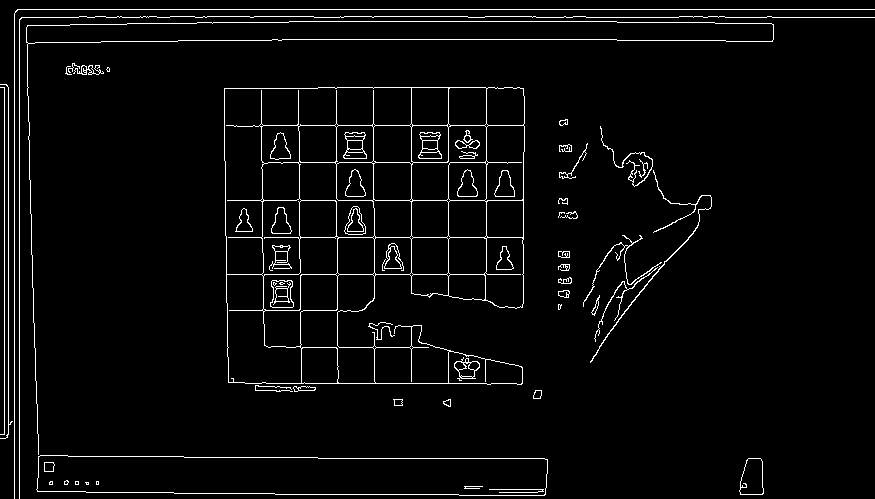

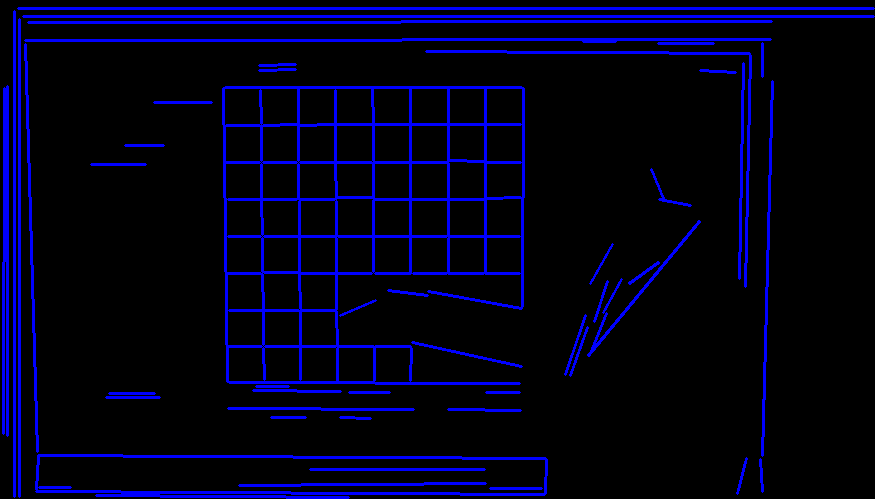

In [4]:
cnt=0
img_edge = edge_detect(img, 40, 300)
W = img_edge.shape[0]
H = img_edge.shape[1]
# lines = get_lines(img_edge)
cv2_imshow(img_edge)
line_id = show_lines(img, lines)


In [5]:
len(line_id)

155

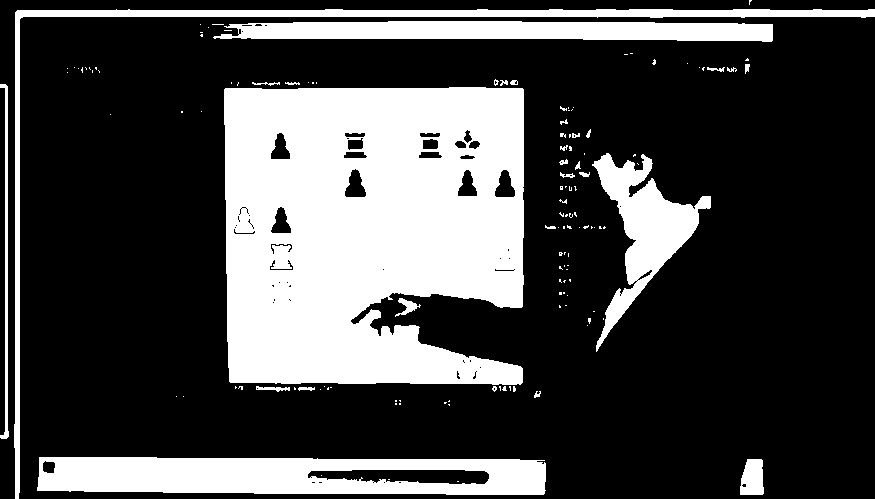

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(th2)

In [7]:
parent = [-1 ]* len(line_id)
size =  [-1 ]* len(line_id)
def make_set(v):
  parent[v] = v
  size[v] = 1

def find_set(v):
  if(v == parent[v]):
    return v
  parent[v] = find_set(parent[v])
  return parent[v]

def union_sets(a,b):
  a = find_set(a)
  b = find_set(b)
  if a != b:
    if(size[a] < size[b]):
      a,b = b,a 
    parent[b] = a
    size[a] += size[b]


In [8]:
from numpy.linalg import norm
import math
import time

def dist(p, p1, p2):
  # t6 = time.time()
  p1p2 = [p2[0] - p1[0], p2[1] - p1[1]]
  p1p = [p[0] - p1[0], p[1] - p1[1]]
  cross = p1p2[0] * p1p[1] - p1p2[1] * p1p[0]
  length = math.sqrt(p1p2[0]**2 + p1p2[1]**2)
  ret = abs(cross)/length
  # t7 = time.time()
  # print(t7-t6)
  return ret

def similar(l1, l2):
  l1x1, l1y1, l1x2, l1y2 = l1
  l2x1, l2y1, l2x2, l2y2 = l2

  #todo: come up with better heuristic
  # t6 = time.time()
  dx1 = dist([l2x1, l2y1], [l1x1, l1y1], [l1x2, l1y2])
  dx2 = dist([l2x2, l2y2], [l1x1, l1y1], [l1x2, l1y2])
  dy1 = dist([l1x2, l1y2], [l2x1, l2y1], [l2x2, l2y2])
  dy2 = dist([l1x1, l1y1], [l2x1, l2y1], [l2x2, l2y2])
  # t7 = time.time()
  # print(t7-t6)
  gamma = 0.25*(dx1 + dx2 + dy1 + dy2) + 0.01
  p = 2
  omega = np.pi/2 * 1/((W*H)**(1/4))
  t_delta = p*omega
  a = math.sqrt((l1y2-l1y1)**2 + (l1x2-l1x1)**2)
  b = math.sqrt((l2y2-l2y1)**2 + (l2x2-l2x1)**2)
  delta = (a + b) * t_delta
  sim = (a/gamma > delta or b/gamma > delta)
  return sim

0.6402256488800049


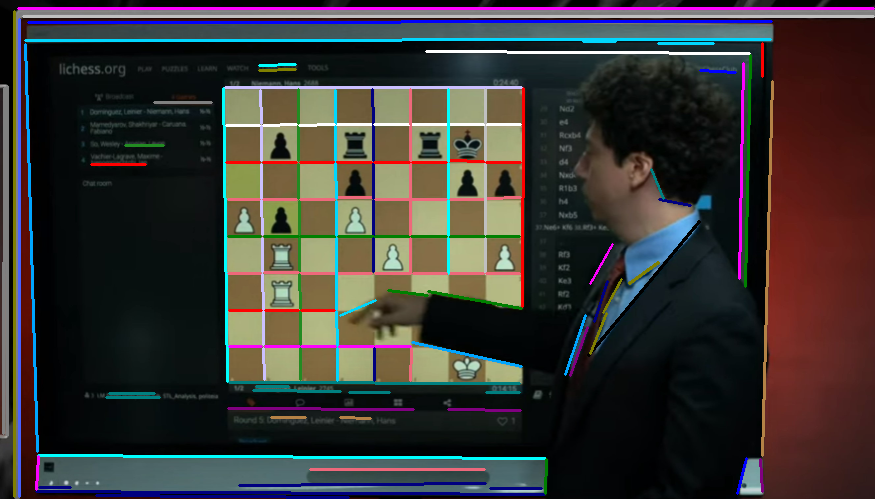

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 13, 14, 15, 16, 3, 8, 19, 20, 19, 22, 23, 24, 25, 8, 27, 28, 9, 19, 31, 19, 19, 31, 19, 36, 37, 31, 39, 37, 39, 42, 43, 39, 45, 39, 47, 39, 45, 47, 43, 39, 31, 37, 55, 56, 47, 58, 59, 39, 59, 39, 43, 64, 56, 56, 37, 68, 43, 68, 43, 72, 9, 42, 55, 42, 68, 45, 56, 25, 59, 25, 25, 37, 72, 72, 47, 56, 89, 43, 72, 68, 43, 72, 59, 59, 56, 31, 68, 68, 42, 42, 25, 55, 25, 37, 72, 37, 9, 47, 72, 59, 56, 9, 56, 55, 25, 55, 72, 64, 121, 55, 123, 9, 19, 126, 127, 25, 19, 43, 37, 132, 55, 8, 25, 55, 137, 138, 139, 140, 141, 142, 138, 144, 145, 146, 147, 148, 8, 150, 16, 146, 9, 16]
defaultdict(<class 'list'>, {0: [array([746.2617 , 458.28128, 737.6617 , 493.31808], dtype=float32)], 1: [array([521.46735, 366.22546, 412.88202, 342.30396], dtype=float32)], 2: [array([223.32408 ,  88.104355, 227.5097  , 381.86597 ], dtype=float32)], 3: [array([428.95142, 291.71512, 521.031  , 308.382  ], dtype=float32), array([388.0155 , 290.18872, 427.06757, 295.44412], dtype

In [9]:
from collections import defaultdict
st= time.time()

for id in range(len(line_id)):
  make_set(id)

t2 = time.time()
for id1 in range(len(line_id)):
  for id2 in range(id1, len(line_id)):
    if similar(line_id[id1], line_id[id2]):  
      union_sets(id1, id2)
t3 = time.time()
print(t3-t2)

colors = [
    (255, 0, 0),    # Red
    (255, 165, 0),  # Orange
    (255, 255, 0),  # Yellow
    (0, 128, 0),    # Green
    (0, 128, 128),  # Teal
    (0, 0, 255),    # Blue
    (128, 0, 128),  # Purple
    (255, 0, 255),  # Magenta
    (128, 0, 0),    # Maroon
    (128, 128, 0),  # Olive
    (128, 128, 128),# Grey
    (192, 192, 192),# Silver
    (255, 255, 255),# White
    (0, 0, 0),      # Black
    (255, 99, 71),  # Tomato
    (255, 192, 203),# Pink
    (255, 215, 0),  # Gold
    (34, 139, 34),  # Forest green
    (70, 130, 180), # Steel blue
    (123, 104, 238) # Medium purple
]

line_image2 = np.copy(img)

groups = defaultdict(list)
for id in range(len(line_id)):
  group_id = find_set(id)
  c = colors[group_id%len(colors)]
  line = line_id[id]
  groups[group_id].append(line)
  x1, y1, x2, y2 = line
  x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
  cv2.line(line_image2,(x1,y1),(x2,y2),c,2)

cv2_imshow(line_image2)

print(parent)
print(groups)

In [10]:
t4 = time.time()
print(similar([0,0,1,1], [2.2,2.3,3,3]))
t5 = time.time()
print(t5-t4)

True
0.0038983821868896484


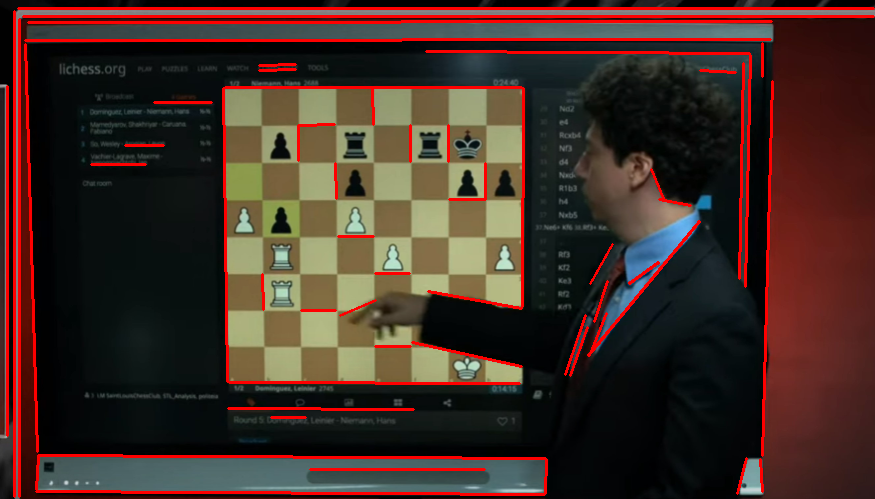

In [11]:
line_image3 = np.copy(img)
merged_lines = []
for group_id in groups:
  group = groups[group_id]
  max_len = 0
  max_idx = 0
  for i,line in enumerate(group):
    length = (line[3]-line[1])**2 + (line[2]-line[0])**2
    if length > max_len:
      max_len = length
      max_idx = i
  line = group[max_idx]
  merged_lines.append(line)
  cv2.line(line_image3,(int(line[0]),int(line[1])),(int(line[2]),int(line[3])),(0,0,255),2)
  
cv2_imshow(line_image3)

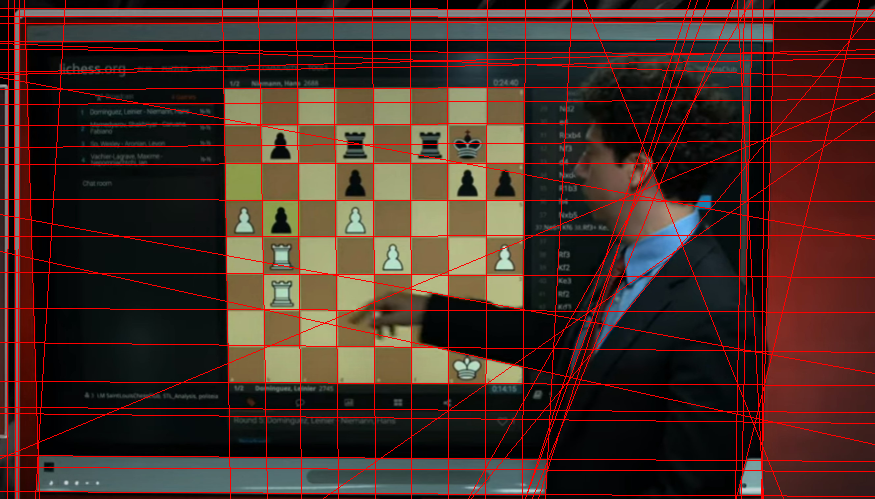

In [12]:
from pickle import TUPLE1
class Line():
  def __init__(self, point, vector):
    self.point = point
    self.vector = vector

full_lines = []
def magnitude(v):
  return math.sqrt(v[0]**2 + v[1]**2)

def find_intersection(l1, l2):
  x1,y1 = l1.point
  u1,v1 = l1.vector
  x2,y2 = l2.point
  u2,v2 = l2.vector
  det = -u1*v2 + v1*u2
  if abs(det) < 0.0000001: 
    return 1000000000, [1000000000, 1000000000]
  t = (-v2*(x2-x1) + u2*(y2-y1))/det
  return [x1 + t*u1, y1 + t*v1]

for line in merged_lines:
  d = [line[2] - line[0], line[3] - line[1]]
  full_lines.append(Line([line[0], line[1]], d))

line_image4 = np.copy(img)

for line in full_lines:
  cv2.line(line_image4,(int(line.point[0]+500*line.vector[0]), int(line.point[1]+500*line.vector[1])),(int(line.point[0] - 500*line.vector[0]), int(line.point[1] - 500*line.vector[1])),(0,0,255),1)
cv2_imshow(line_image4)


In [13]:
# import torch
# from torchvision import transforms
# model = torch.load('resnet18.pth', map_location=torch.device('cpu'))
# model.eval()

# def predict_image(im):
#   edges = edge_detect(im)
#   edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
#   pred = model(transforms.ToTensor()(edges).unsqueeze(0))
#   prob = torch.sigmoid(pred).item()
#   value = 1 if prob > 0.5 else 0
#   return value

In [14]:
templates = [np.array(
    [[0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0]],
    dtype=np.uint8
), np.array(
    [[255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255, 0, 0, 0, 0],
      [255, 255, 255, 255,0, 0, 0, 0],
      [255, 255, 255, 255,0, 0, 0, 0],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255],
      [0, 0, 0, 0, 255, 255, 255, 255]],
    dtype=np.uint8
)]

# templates = [np.array(
#     [[0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255],
#     [255, 255, 255, 0, 0, 0],
#     [255, 255, 255, 0, 0, 0],
#     [255, 255, 255,  0, 0, 0]],
#     dtype=np.uint8
# ), np.array(
#     [[255, 255, 255,  0, 0, 0],
#     [255, 255, 255,  0, 0, 0],
#     [255, 255, 255, 0, 0, 0],
#     [0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255],
#     [0, 0, 0, 255, 255, 255]],
#     dtype=np.uint8
# )]

In [15]:
def detect_lattice(im):
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  th =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,21,2)
  for template in templates:
    res = cv2.matchTemplate(th,template,cv2.TM_CCORR_NORMED)
    loc = np.where( res >= 0.9)
    if len(loc[0]) > 0 or len(loc[1]) > 0:
      return True
  return False
  # ret, corners = cv2.findChessboardCorners(th, (3,3), None)
  # cv2.drawChessboardCorners(th, (3,3), corners,ret)


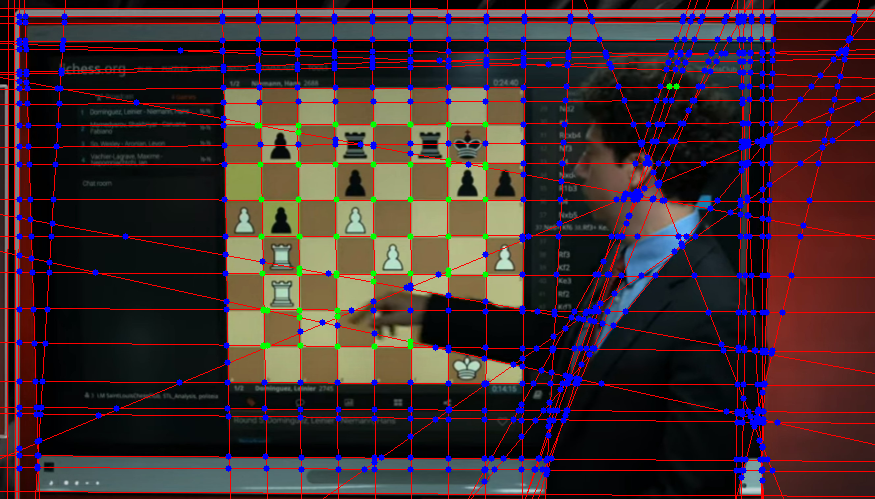

In [19]:
inter_images = []
lattice_points = []
for i in range(len(full_lines)):
  for j in range(i+1, len(full_lines)):
    point_inter = find_intersection(full_lines[i], full_lines[j])
    if(point_inter[0] >= 16 and point_inter[0] < H-16 and point_inter[1] >= 16 and point_inter[1] < W-16):
      
      roi = img[int(point_inter[1])-12: int(point_inter[1])+12, int(point_inter[0])-12: int(point_inter[0])+12]
      if(len(roi) == 0):
        print("empty")
        print(point_inter[0], point_inter[1])
      inter_images.append(roi)

      is_lattice = detect_lattice(roi)
      if is_lattice == 1:
        cv2.circle(line_image4, (int(point_inter[0]), int(point_inter[1])), 3, (0, 255, 0), -1)
        lattice_points.append(point_inter)
      else:
        cv2.circle(line_image4, (int(point_inter[0]), int(point_inter[1])), 3, (255, 0, 0), -1)
cv2_imshow(line_image4)

In [17]:
# import torch
# from torchvision import transforms
# model = torch.load('resnet18.pth', map_location=torch.device('cpu'))
# model.eval()
# for im in inter_images:
#   edges = edge_detect(im)
#   edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
#   cv2_imshow(edges)
#   pred = model(transforms.ToTensor()(edges).unsqueeze(0))
#   prob = torch.sigmoid(pred).item()
#   value = 1 if prob > 0.5 else 0
#   print(value)


In [22]:
len(lattice_points)
type(lattice_points[0])
        

list

# Scoring


In [33]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=50, min_samples=3).fit(lattice_points)

clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [45]:
labels = clustering.labels_
clusters = [[] for _ in range(max(labels)+1)]

for point, cluster in zip(lattice_points, labels):
  if cluster >= 0:
    clusters[cluster].append(point)

clusters.sort(key=lambda x: -len(x))
biggest_cluster = clusters[0]
biggest_cluster = np.array([np.array([num for num in nums]) for nums in biggest_cluster])

hull = cv2.convexHull(biggest_cluster)
area = cv2.contourArea(hull)

In [46]:
grid_len = math.sqrt(area)/7
grid_len

31.04453315876578